In [1]:
import orbax.checkpoint as ocp
from ml_collections import ConfigDict
from pathlib import Path
from utils import prepare_test_dataset
from dataset_utils import get_dataset
from jax import random
from models.utils import sample_gaussian

import models.ClassifierGFZ as ClassifierGFZ
import models.ClassifierDFZ as ClassifierDFZ

checkpoint_path = "gfz-2-epochs-first-try-1"
path = Path.cwd() / Path(f"checkpoints") / Path(checkpoint_path)
checkpoint = ocp.PyTreeCheckpointer().restore(path, item=None)

config = ConfigDict(checkpoint["config"])
dataset_config = ConfigDict(checkpoint["dataset_config"])

if config.model_name == "GFZ":
    classifier = ClassifierGFZ
elif config.model_name == "DFZ":
    classifier = ClassifierDFZ
else:
    raise NotImplementedError(config.model_name)

train_ds, test_ds = get_dataset(config.dataset)
test_images, test_labels = prepare_test_dataset(
    test_ds, dataset_config
    )
train_images, train_labels = prepare_test_dataset(
    train_ds, dataset_config
    )

trained_params = checkpoint["params"]

log_likelyhood_fn = classifier.log_likelyhood_A

test_key = random.PRNGKey(config.seed)

test_key, model, _ = classifier.create_and_init(
    test_key, config, dataset_config
)

/Users/alexandrelutt/Desktop/Travail/ENPC/3A/MVA/Probabilistic Graphical Models/adversarial-attacks-on-generative-classifiers/.venv/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1346: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [2]:
from flax import linen as nn
import jax
from jax import jacrev
import numpy as np
from functools import partial
from jax.scipy.special import logsumexp
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import softmax

def init_data(test_key, type='test', n_samples=10):
    if type == 'test':
        idx = np.random.choice(range(len(test_images)), n_samples, replace=False)

        all_xs = test_images[idx]
        true_ys = test_labels[idx]
    elif type == 'train':
        idx = np.random.choice(range(len(train_images)), n_samples, replace=False)

        all_xs = train_images[idx]
        true_ys = train_labels[idx]
        
    true_labels = np.argmax(true_ys, axis=1)

    K = model.K
    batch_size = n_samples
    test_key, epsilons = sample_gaussian(test_key, (batch_size, model.n_classes * K, model.d_latent))
    epsilons = epsilons[:n_samples*model.n_classes]
    all_ys = nn.one_hot(jnp.repeat(jnp.arange(model.n_classes), K), model.n_classes, dtype=jnp.float32)
    
    return all_xs, true_labels, epsilons, all_ys, K, test_key

def get_model_output(x, epsilon, y, K):
    z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz = jax.vmap(
            partial(model.apply, {'params': trained_params}, train=False),
            in_axes=(None, 0, 0)
        )(x, y, epsilon)

    ll = log_likelyhood_fn(
            z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz
        ).reshape(model.n_classes, K)
    ll = logsumexp(ll, axis=1) - np.log(K)
    return ll

def get_model_jacobian(x, epsilon, y, K):
    return jacrev(get_model_output, argnums=0)(x, epsilon, y, K)

def map_label_to_name(y):
    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    return labels[y]

In [3]:
class DeepFool():
    def __init__(self, model, max_iter=10, learning_rate=1, p=2):
        self.model = model
        self.n_classes = model.n_classes
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        assert p > 1 
        self.p = p
        if self.p == np.inf:
            self.q = 1
        else:
            self.q = self.p/(self.p-1)

    def qnorm(self, x):
        return np.linalg.norm(x.flatten(), self.q)

    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon, self.y, self.K)
        return np.argmax(val)

    def get_likelihoods_and_gradients(self, x, epsilon):
        J = get_model_jacobian(x, epsilon, self.y, self.K)
        val = get_model_output(x, epsilon, self.y, self.K)
        return val, J

    def get_perturbation(self, x, epsilon, all_ys, K):
        corrupted_x = x.copy()
        self.y = all_ys
        self.K = K
        new_label = self.get_label(corrupted_x, epsilon)
        k = self.get_label(x, epsilon)
        for _ in range(self.max_iter):
            best_pert = np.inf
            likelihoods, gradients = self.get_likelihoods_and_gradients(corrupted_x, epsilon)
            for j in range(self.n_classes):
                if j != k:
                    w_j = gradients[j] - gradients[k]
                    f_j = likelihoods[j] - likelihoods[k]
                    pert = np.abs(f_j) / self.qnorm(w_j)
                    if pert < best_pert:
                        w = w_j
                        f = f_j
            r_i = (np.abs(f) / self.qnorm(w)**self.q) * (np.sign(w) * np.abs(w)**(self.q-1))
            corrupted_x = corrupted_x + self.learning_rate*r_i
            new_label = self.get_label(corrupted_x, epsilon)
            if new_label != k:
                break
        if new_label == k:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
        else:
            perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
        return corrupted_x, new_label, perturbation_norm

class FastGradientSign():
    def __init__(self, model, eta=0.3):
        self.model = model
        self.eta = eta

    def get_likelihoods_and_gradients(self, x, epsilon):
        J = get_model_jacobian(x, epsilon, self.y, self.K)
        val = get_model_output(x, epsilon, self.y, self.K)
        return val, J
    
    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon, self.y, self.K)
        return np.argmax(val)

    def get_perturbation(self, x, epsilon, all_ys, K):
        corrupted_x = x.copy()  
        self.y = all_ys
        self.K = K
        original_label = self.get_label(x, epsilon)
        _, gradients = self.get_likelihoods_and_gradients(corrupted_x, epsilon)
        perturbations = np.array([self.eta * np.sign(g) for g in gradients])
        perturbated_labels = np.array([self.get_label(x+p, epsilon) for p in perturbations])
        different_labels_ids = np.where(perturbated_labels != original_label)
        if len(different_labels_ids[0]) == 0:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
            new_label = original_label
            smallest_perturbation = np.argmin(np.linalg.norm(perturbations, axis=0))
            corrupted_x = x + smallest_perturbation
        else:
            different_labels_norms = np.array([np.linalg.norm(p) for p in perturbations])[different_labels_ids]
            corrupted_x = x + perturbations[np.argmin(different_labels_norms)]
            new_label = self.get_label(corrupted_x, epsilon)
            perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
        return corrupted_x, new_label, perturbation_norm

In [4]:
def generate_p_bayes(corruption_model, n_samples, all_xs, epsilons, true_labels, all_ys, K, corruption=True):
    all_generated_p_bayes = np.zeros((n_samples, 10))
    well_classified = []
    for i in tqdm(range(n_samples)):
        x = all_xs[i]
        epsilon = epsilons[i]
        if corruption:
            corrupted_x, _, _ = corruption_model.get_perturbation(x, epsilon, all_ys, K)
        else:
            corrupted_x = x
        ll = get_model_output(corrupted_x, epsilon, all_ys, K)
        p_bayes = softmax(ll)
        if true_labels[i] == np.argmax(p_bayes):
            well_classified.append(i)
        all_generated_p_bayes[i] = p_bayes
    return all_generated_p_bayes, well_classified

def evaluate_treshold(alpha):
    tresholds = means - alpha*stds

    detections = 0
    for i in range(n_samples):
        p_bayes = all_generated_p_bayes[i]
        if np.max(p_bayes) < tresholds[generated_predictions[i]]:
            detections += 1
    detection_rate = detections/n_samples

    false_positives = 0
    for i in well_classified:
        p_bayes = all_true_p_bayes[i]
        if np.max(p_bayes) < tresholds[true_predictions[i]]:
            false_positives += 1
    false_positive_rate = false_positives/len(well_classified)

    return detection_rate, false_positive_rate

def display_roc_curve(false_positives_list, detection_list):
    plt.plot(false_positives_list, detection_list)
    plt.xlabel("False positives")
    plt.ylabel("Detection rate")
    plt.title("ROC curve")
    plt.show()

  1%|          | 1/100 [00:03<06:05,  3.69s/it]

  6%|▌         | 6/100 [00:22<06:01,  3.84s/it]

 46%|████▌     | 46/100 [02:45<03:12,  3.56s/it]

 62%|██████▏   | 62/100 [03:43<02:21,  3.72s/it]

 71%|███████   | 71/100 [04:18<01:46,  3.68s/it]

 90%|█████████ | 90/100 [05:26<00:35,  3.58s/it]

100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


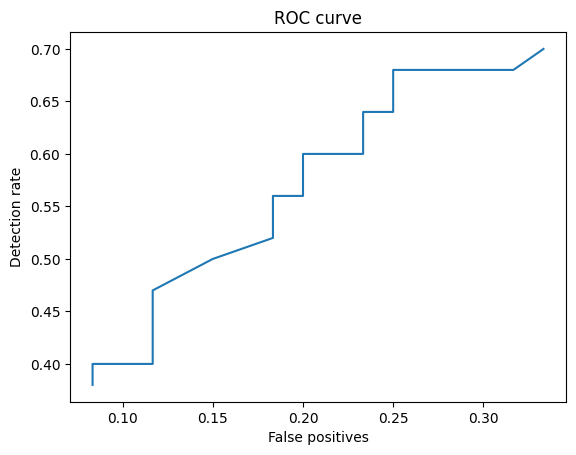

In [7]:
## sample from test set to generate perturbations 
n_samples = 100
all_xs_test, true_labels_test, epsilons_test, all_ys_test, K_test, test_key = init_data(test_key, type='test', n_samples=n_samples)

corruption_model = FastGradientSign(model)
all_generated_p_bayes, _ = generate_p_bayes(corruption_model, n_samples, all_xs_test, epsilons_test, true_labels_test, all_ys_test, K_test)
generated_predictions = np.argmax(all_generated_p_bayes, axis=1)

## sample from train set to estimate tresholds
all_xs_train, true_labels_train, epsilons_train, all_ys_train, K_train, test_key = init_data(test_key, type='train', n_samples=n_samples)

all_true_p_bayes, well_classified = generate_p_bayes(corruption_model, n_samples, all_xs_train, epsilons_train, true_labels_train, all_ys_train, K_train, corruption=False)
true_predictions = np.argmax(all_true_p_bayes, axis=1)

## dictionary of p_bayes for each class (only keeping well classified samples)
values = {i:[] for i in range(10)}

for i in range(n_samples):
    values[true_predictions[i]].append(all_true_p_bayes[i][true_predictions[i]])

means = np.array([np.mean(values[i]) for i in range(10)])
stds = np.array([np.std(values[i]) for i in range(10)])

detection_list, false_positives_list = [], []

for alpha in np.linspace(0., 1, 50):
    detections, false_positives = evaluate_treshold(alpha)
    detection_list.append(detections)
    false_positives_list.append(false_positives)

display_roc_curve(false_positives_list, detection_list)

 83%|████████▎ | 83/100 [03:20<00:34,  2.05s/it]

100%|██████████| 100/100 [04:06<00:00,  2.46s/it]


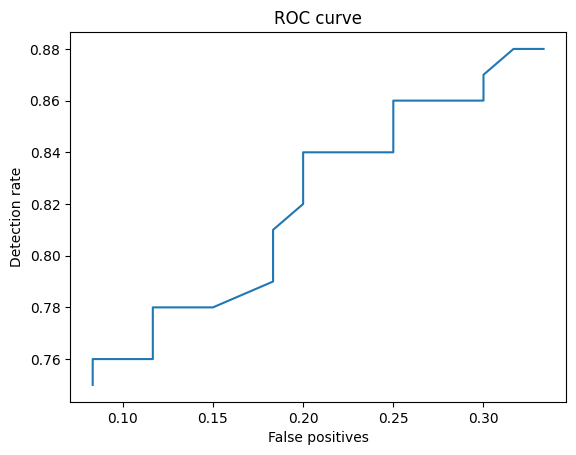

In [8]:
corruption_model = DeepFool(model)
all_generated_p_bayes, _ = generate_p_bayes(corruption_model, n_samples, all_xs_test, epsilons_test, true_labels_test, all_ys_test, K_test)
generated_predictions = np.argmax(all_generated_p_bayes, axis=1)

## dictionary of p_bayes for each class (only keeping well classified samples)
values = {i:[] for i in range(10)}

for i in range(n_samples):
    values[true_predictions[i]].append(all_true_p_bayes[i][true_predictions[i]])

means = np.array([np.mean(values[i]) for i in range(10)])
stds = np.array([np.std(values[i]) for i in range(10)])

detection_list, false_positives_list = [], []

for alpha in np.linspace(0., 1, 50):
    detections, false_positives = evaluate_treshold(alpha)
    detection_list.append(detections)
    false_positives_list.append(false_positives)

display_roc_curve(false_positives_list, detection_list)